# Wavelet transform

Source - http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [1]:
import sys
sys.path.append('ts_fe/')

import numpy as np
import pandas as pd
import pywt

import matplotlib.pyplot as plt
import seaborn as sns

from src.signal_processing import *

import warnings
warnings.filterwarnings("ignore")

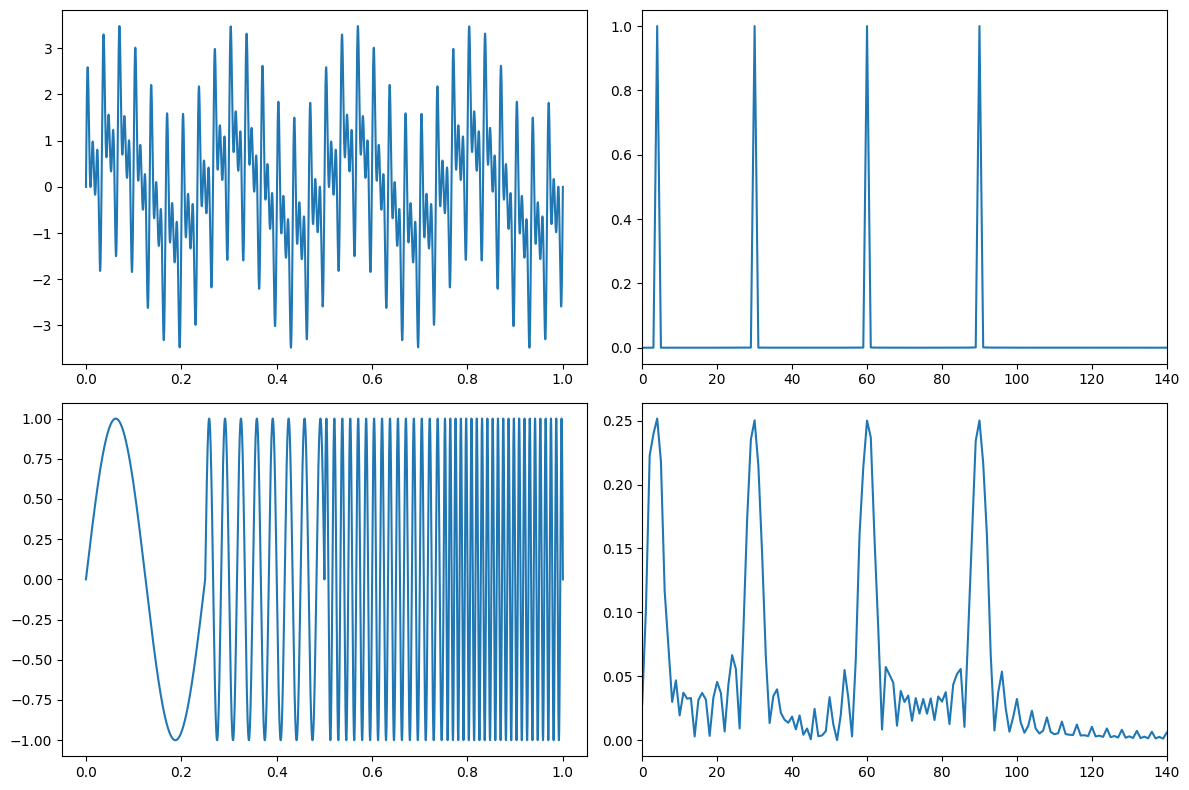

In [2]:
t_n = 1
N = 100000
T = t_n / N
f_s = 1/T

xa = np.linspace(0, t_n, num=N)
xb = np.linspace(0, t_n/4, num=int(N/4))

frequencies = [4, 30, 60, 90]
y1a, y1b = np.sin(2*np.pi*frequencies[0]*xa), np.sin(2*np.pi*frequencies[0]*xb)
y2a, y2b = np.sin(2*np.pi*frequencies[1]*xa), np.sin(2*np.pi*frequencies[1]*xb)
y3a, y3b = np.sin(2*np.pi*frequencies[2]*xa), np.sin(2*np.pi*frequencies[2]*xb)
y4a, y4b = np.sin(2*np.pi*frequencies[3]*xa), np.sin(2*np.pi*frequencies[3]*xb)

composite_signal1 = y1a + y2a + y3a + y4a
composite_signal2 = np.concatenate([y1b, y2b, y3b, y4b])

f_values1, fft_values1 = get_fft_values(composite_signal1, T, N, f_s)
f_values2, fft_values2 = get_fft_values(composite_signal2, T, N, f_s)

fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
axarr[0,0].plot(xa, composite_signal1)
axarr[1,0].plot(xa, composite_signal2)
axarr[0,1].plot(f_values1, fft_values1)
axarr[0,1].set_xlim(0, 140)
axarr[1,1].plot(f_values2, fft_values2)
axarr[1,1].set_xlim(0, 140)

plt.tight_layout()
plt.show()

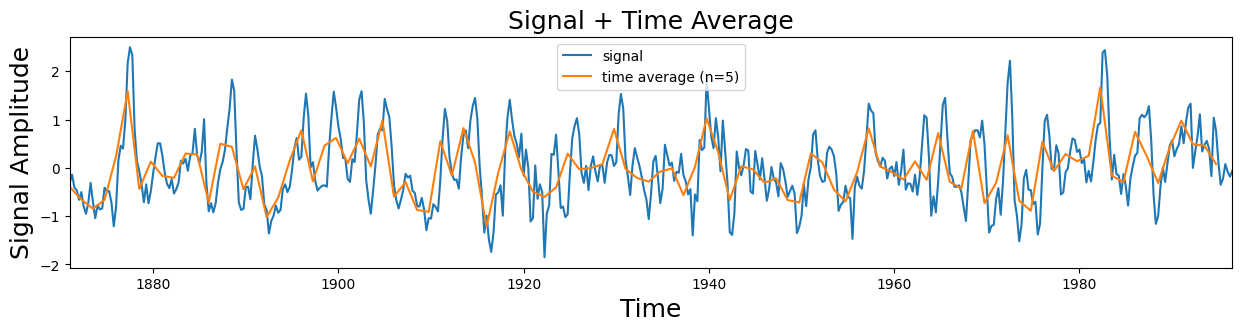

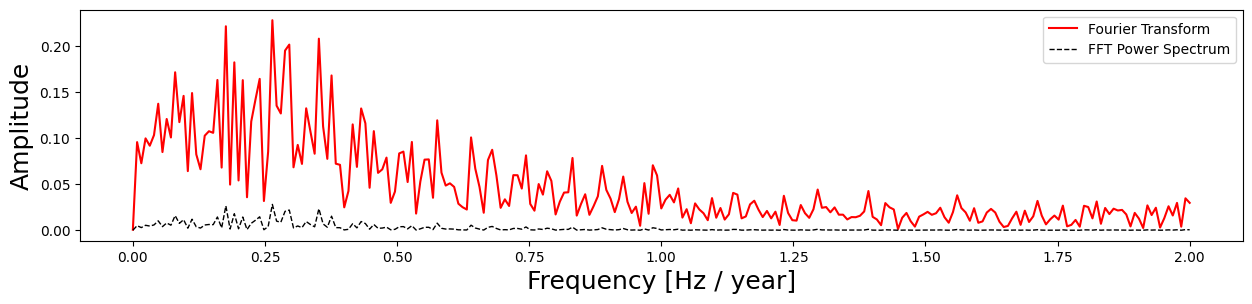

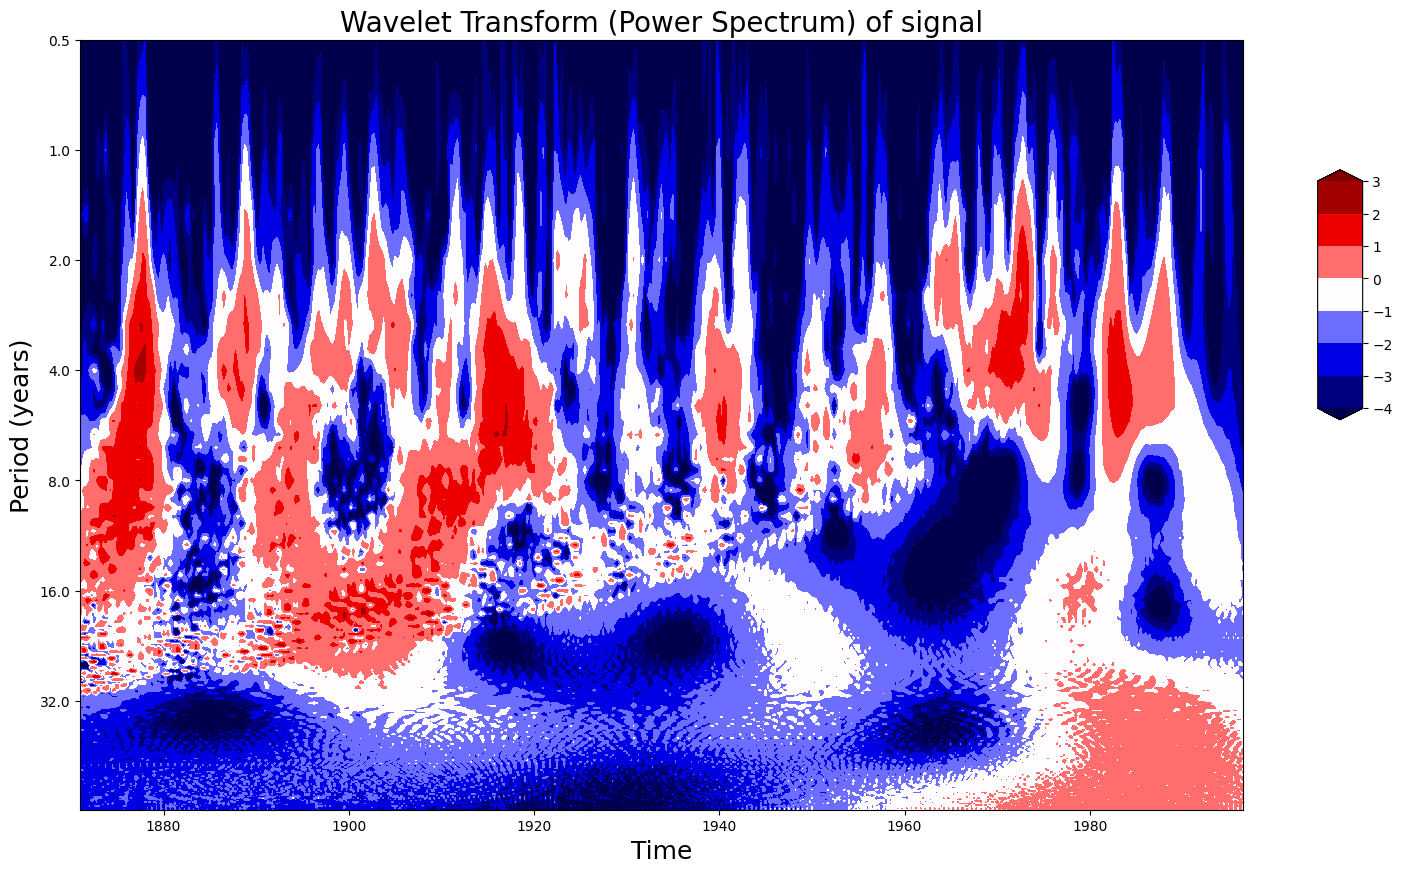

In [3]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(
        time, np.log2(period), np.log2(power), 
        contourlevels, extend='both',cmap=cmap
    )
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()

    
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave
    
def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
 
def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()

dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()
 
scales = np.arange(1, 128)
plot_signal_plus_average(time, signal)
plot_fft_plus_power(time, signal)
plot_wavelet(time, signal, scales)

![](https://upload.wikimedia.org/wikipedia/commons/9/95/Continuous_wavelet_transform.gif)

<img src="https://ataspinar.com/wp-content/uploads/2018/12/wavelet_convolution_3d_2d_final.gif" width=500>